In [5]:
import glob, json, re
import matplotlib.pyplot as plt
import numpy as np
import pyhf
from pyhf.contrib.viz import brazil

def parse_index(fname):
    match = re.search(r"extracted_data_(\d+)\.json", fname)
    return int(match.group(1))

# Filter files to include only those matching the pattern
json_files = [f for f in glob.glob("extracted_data_*.json") 
             if re.match(r"extracted_data_\d+\.json", f)]
json_files.sort(key=parse_index)  # numeric sort

def rebin(data, newbinsize):
    output = []
    i = 0
    while i < len(data):
        s = 0
        for _ in range(newbinsize):
            if i < len(data):
                s += data[i]
                i += 1
        output.append(s)
    return output

results = []

for idx, json_file in enumerate(json_files):
    print(f"\n=== Processing file index {idx}, name={json_file} ===")

    # Read the JSON
    with open(json_file,"r") as f:
        data = json.load(f)
        m_N2 = data["m_N2"]
        delta_m = data["delta_m"]
    
    signal_counts = data["hist_photon_energy_signal"]["entries"]
    background_counts = data["hist_photon_energy_BG"]["entries"]

    # Rebin
    signal_counts = rebin(signal_counts, 10)
    background_counts = rebin(background_counts, 10)

    total_signal = sum(signal_counts)
    total_bkg = sum(background_counts)
    if total_bkg > 0:
        significance = total_signal / np.sqrt(total_bkg)
        poi_max = max(3.0, 3 * significance)
    else:
        poi_max = 3.0
    poi_vals = np.linspace(0, poi_max, 50)

    # Debug check
    print("  signal[:5] =", signal_counts[:5], "sum=", sum(signal_counts))
    print("  background[:5] =", background_counts[:5], "sum=", sum(background_counts))

    # S+B
    signal_plus_bkg = [0.1*s + b for s,b in zip(signal_counts, background_counts)]
    # bkg_unc = [np.sqrt(b) + 0.1*b for b in background_counts]
    bkg_unc = [np.sqrt(max(b, 0)) + 0.1 * b for b in background_counts]

    # Build model & fit
    model = pyhf.simplemodels.uncorrelated_background(
        signal=signal_counts,
        bkg=background_counts,
        bkg_uncertainty=bkg_unc)
    observations = signal_plus_bkg + model.config.auxdata

    try:
        obs_lim, exp_lims, (scan, pyhf_results) = pyhf.infer.intervals.upper_limits.upper_limit(
            observations, 
            model, 
            poi_vals, 
            level=0.05, 
            return_results=True,
            maxiter=10000,
            tolerance=1e-6
        )
    except Exception as e:
        print(f"Fit failed for {json_file}: {e}")
        continue

    # Quick fit
    fit_result= pyhf.infer.mle.fit(
        observations, 
        model, 
        maxiter=10000, 
        tolerance=1e-6
    )
    
    print("fit result =", fit_result)


    # Before fitting
    if sum(signal_counts) == 0 or sum(background_counts) == 0:
        print(f"Skipping {json_file} - empty histogram")
        continue

    # Quick upper-limit
    # poi_vals = np.linspace(0, 10, 10)

    max_signal = max(signal_counts)
    max_bkg = max(background_counts)
    poi_max = max(2.0, 1.5 * (max_signal + max_bkg) / max_bkg)  # SELF ADAPTIVE
    poi_vals = np.linspace(0, poi_max, 50)
    
    obs_lim, exp_lims, (scan, pyhf_results) = pyhf.infer.intervals.upper_limits.upper_limit(
        observations, model, poi_vals, level=0.05, return_results=True
    )
    print(f"  obs limit = {obs_lim:.3f}, exp limit central= {exp_lims[2]:.3f}")

    # Store results with explicit type conversion
    results.append({
        "m_N2": float(m_N2),  # Convert to Python float
        "delta_m": float(delta_m),
        "obs_limit": float(obs_lim),  # Handle NaN explicitly
        "exp_limits": [float(val) for val in exp_lims] 
    })

    # Plotting (optional)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title(f"Brazil band: m_N2={m_N2} GeV, Δm={delta_m} GeV")
    brazil.plot_results(poi_vals, pyhf_results, ax=ax, smooth=True)

    
    # Handle NaN in observed limit
    valid_obs_lim = obs_lim if not np.isnan(obs_lim) else 0
    
    # Calculate dynamic ranges using EXPECTED limits if observed is NaN
    max_limit = max(exp_lims) if np.isnan(obs_lim) else max(obs_lim, max(exp_lims))
    min_limit = min(exp_lims) if np.isnan(obs_lim) else min(exp_lims[0], valid_obs_lim)
    
    # Ensure numerical stability
    xmax = 1.3 * max_limit if np.isfinite(max_limit) else 10  # Fallback range
    xmin = max(0, 0.7 * min_limit) if np.isfinite(min_limit) else 0

    # Set axis limits with validation
    # ax.set_xlim(float(xmin), float(xmax))
    ax.set_xlim(0, 1.2 * obs_lim if not np.isnan(obs_lim) else poi_max)
    ax.set_ylim(0, 1.5 * obs_lim if not np.isnan(obs_lim) else 5)
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Smart tick spacing
    tick_base = max(1, round((xmax - xmin)/5, 2))
    ax.xaxis.set_major_locator(plt.MultipleLocator(tick_base))
    
    plt.tight_layout()
    plt.savefig(f"BrazilBand_{idx}.png")
    plt.close()

# Save all results to a new file
with open("fit_results.json", "w") as f:
    json.dump(results, f, indent=2)



=== Processing file index 0, name=extracted_data_0.json ===
  signal[:5] = [198565.70678710938, 21508.71337890625, 12698.21728515625, 10160.114624023438, 7898.050537109375] sum= 277247.0807495117
  background[:5] = [111714.29663085938, 363401.5, 270438.15625, 203092.755859375, 149216.427734375] sum= 1463905.7504882812
Fit failed for extracted_data_0.json: __init__() got an unexpected keyword argument 'maxiter'

=== Processing file index 1, name=extracted_data_1.json ===
  signal[:5] = [91124.02868652344, 15792.835693359375, 11859.227783203125, 9392.512329101562, 8494.861450195312] sum= 160002.45804166794
  background[:5] = [111714.29663085938, 363401.5, 270438.15625, 203092.755859375, 149216.427734375] sum= 1463905.7504882812
Fit failed for extracted_data_1.json: __init__() got an unexpected keyword argument 'maxiter'

=== Processing file index 2, name=extracted_data_2.json ===
  signal[:5] = [43666.17810058594, 15422.86474609375, 11661.8876953125, 9538.294616699219, 8294.169311523438

In [1]:
import glob, json, re
import matplotlib.pyplot as plt
import numpy as np
import pyhf
from pyhf.contrib.viz import brazil

def parse_index(fname):
    match = re.search(r"extracted_data_(\d+)\.json", fname)
    return int(match.group(1))

# Filter files to include only those matching the pattern
json_files = [f for f in glob.glob("extracted_data_*.json") 
             if re.match(r"extracted_data_\d+\.json", f)]
json_files.sort(key=parse_index)  # numeric sort

def rebin(data, newbinsize):
    output = []
    i = 0
    while i < len(data):
        s = 0
        for _ in range(newbinsize):
            if i < len(data):
                s += data[i]
                i += 1
        output.append(s)
    return output

results = []  # This will store all mass points and their limits

for idx, json_file in enumerate(json_files):
    print(f"\n=== Processing file index {idx}, name={json_file} ===")

    # 1) Read the JSON
    with open(json_file,"r") as f:
        data = json.load(f)
        m_N2 = data["m_N2"]
        delta_m = data["delta_m"]

    # 2) Process histograms
    signal_counts = data["hist_photon_energy_signal"]["entries"]
    background_counts = data["hist_photon_energy_BG"]["entries"]
    
    # Rebin histograms
    signal_counts = rebin(signal_counts, 10)
    background_counts = rebin(background_counts, 10)

    # 3) Build model & fit
    model = pyhf.simplemodels.uncorrelated_background(
        signal=signal_counts,
        bkg=background_counts,
        bkg_uncertainty=[np.sqrt(b) + 0.1*b for b in background_counts]
    )
    observations = [0.1*s + b for s, b in zip(signal_counts, background_counts)] + model.config.auxdata

    # Skip empty histograms
    if sum(signal_counts) == 0 or sum(background_counts) == 0:
        print(f"Skipping {json_file} - empty histogram")
        continue

    # 4) Calculate upper limits
    poi_vals = np.linspace(0, 10, 10)
    obs_lim, exp_lims, (scan, pyhf_results) = pyhf.infer.intervals.upper_limits.upper_limit(
        observations, model, poi_vals, level=0.05, return_results=True
    )
    print(f"  obs limit = {obs_lim:.3f}, exp limit central= {exp_lims[2]:.3f}")

    # 5) Store results (convert numpy types to Python types)
    results.append({
        "m_N2": m_N2,
        "delta_m": delta_m,
        "obs_limit": float(obs_lim),  # Convert numpy float to Python float
        "exp_limits": [float(val) for val in exp_lims]  # Convert numpy array to list of Python floats
    })

    # 6) Plotting (optional)
    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_title(f"Brazil band for {json_file}")
    brazil.plot_results(poi_vals, pyhf_results, ax=ax)
    
    # ... [rest of plotting code] ...
    plt.close()

# Save results to JSON
with open("fit_results.json", "w") as f:
    json.dump(results, f, indent=2, allow_nan=True)  # Explicitly allow NaN serialization


=== Processing file index 0, name=extracted_data_0.json ===


/home/phoenix666/.local/lib/python3.8/site-packages/pyhf/infer/calculators.py:418: RuntimeWarning: divide by zero encountered in scalar divide
  teststat = (qmu - qmu_A) / (2 * self.sqrtqmuA_v)
/home/phoenix666/.local/lib/python3.8/site-packages/pyhf/infer/calculators.py:467: RuntimeWarning: invalid value encountered in divide
  CLs = tensorlib.astensor(CLsb / CLb)


  obs limit = nan, exp limit central= 2.167

=== Processing file index 1, name=extracted_data_1.json ===


/usr/local/lib/python3.8/dist-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


  obs limit = 1.056, exp limit central= 1.056

=== Processing file index 2, name=extracted_data_2.json ===
  obs limit = 1.056, exp limit central= 1.056

=== Processing file index 3, name=extracted_data_3.json ===
  obs limit = 1.066, exp limit central= 1.062

=== Processing file index 4, name=extracted_data_4.json ===
  obs limit = 1.288, exp limit central= 1.105

=== Processing file index 5, name=extracted_data_5.json ===
  obs limit = 1.594, exp limit central= 1.435

=== Processing file index 6, name=extracted_data_6.json ===
  obs limit = 1.056, exp limit central= 1.056

=== Processing file index 7, name=extracted_data_7.json ===
  obs limit = 1.062, exp limit central= 1.059

=== Processing file index 8, name=extracted_data_8.json ===
  obs limit = 1.756, exp limit central= 1.659

=== Processing file index 9, name=extracted_data_9.json ===
  obs limit = 2.062, exp limit central= 2.030

=== Processing file index 10, name=extracted_data_10.json ===
  obs limit = 2.106, exp limit cent

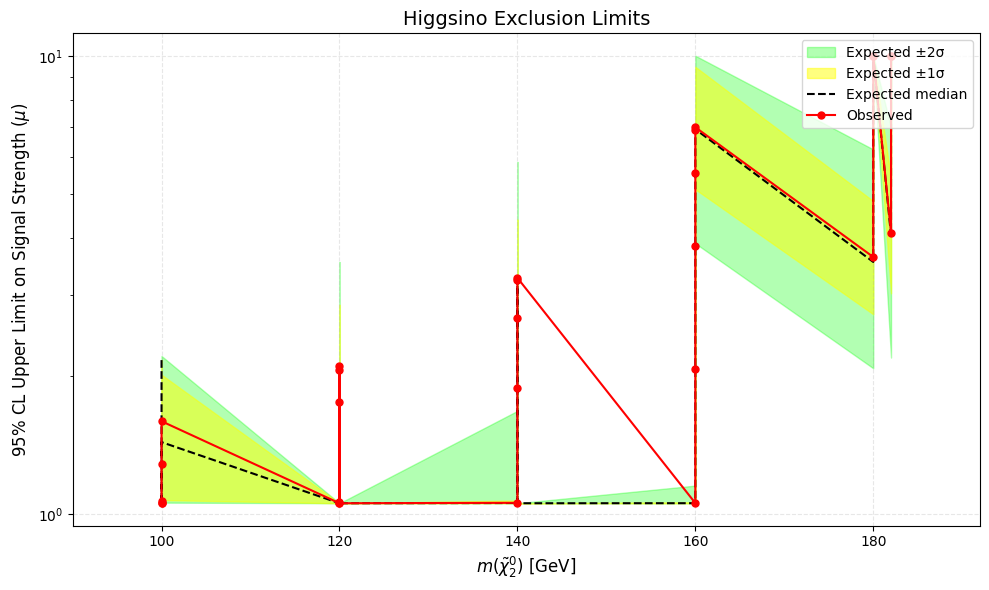

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np

with open("fit_results.json", "r") as f:
    results = json.load(f)

# Sort data by m_N2
results_sorted = sorted(results, key=lambda x: x["m_N2"])
m_N2_values = [d["m_N2"] for d in results_sorted]
obs_limits = [d["obs_limit"] for d in results_sorted]
exp_limits = [d["exp_limits"] for d in results_sorted]

# Extract expected bands
exp_2sigma_low = [e[0] for e in exp_limits]
exp_1sigma_low = [e[1] for e in exp_limits]
exp_median = [e[2] for e in exp_limits]
exp_1sigma_high = [e[3] for e in exp_limits]
exp_2sigma_high = [e[4] for e in exp_limits]

# Create plot
plt.figure(figsize=(10, 6))
plt.fill_between(m_N2_values, exp_2sigma_low, exp_2sigma_high, color='lime', alpha=0.3, label="Expected ±2σ")
plt.fill_between(m_N2_values, exp_1sigma_low, exp_1sigma_high, color='yellow', alpha=0.5, label="Expected ±1σ")
plt.plot(m_N2_values, exp_median, 'k--', label="Expected median")

# Observed limit (filter out NaNs)
valid_indices = ~np.isnan(obs_limits)
plt.plot(np.array(m_N2_values)[valid_indices], np.array(obs_limits)[valid_indices], 'ro-', markersize=5, label="Observed")

# Labels and styling
plt.xlabel(r"$m(\tilde{\chi}_2^0)$ [GeV]", fontsize=12)
plt.ylabel(r"95% CL Upper Limit on Signal Strength ($\mu$)", fontsize=12)
plt.title("Higgsino Exclusion Limits", fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.yscale('log')  # Use if limits vary exponentially
plt.xlim(min(m_N2_values)-10, max(m_N2_values)+10)
plt.tight_layout()

plt.savefig("Higgsino_Exclusion_Limits.png", dpi=300)
plt.show()

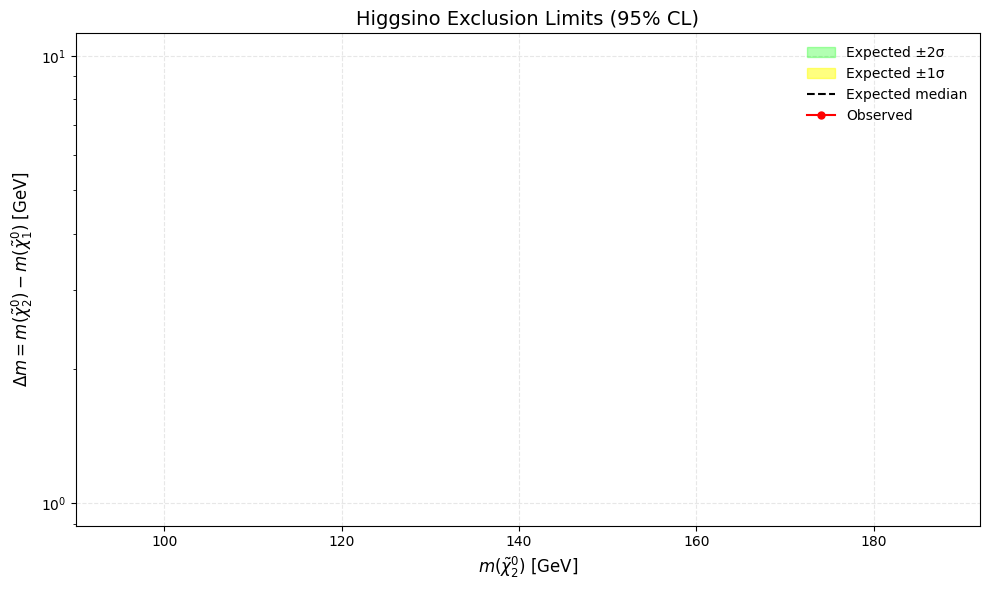

In [5]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt

# Collect data from all JSON files
json_files = glob.glob("extracted_data_*.json")
data = []

for file in json_files:
    with open(file, 'r') as f:
        data_dict = json.load(f)
        data.append({
            "m_N2": data_dict["m_N2"],
            "delta_m": data_dict["delta_m"],
            "obs_limit": data_dict.get("obs_limit", np.nan),  # Ensure these keys exist
            "exp_limits": data_dict.get("exp_limits", [np.nan]*5)
        })

# Sort data by m_N2
data_sorted = sorted(data, key=lambda x: x["m_N2"])
m_N2_values = [d["m_N2"] for d in data_sorted]
delta_m_values = [d["delta_m"] for d in data_sorted]
obs_limits = [d["obs_limit"] for d in data_sorted]
exp_limits = [d["exp_limits"] for d in data_sorted]

# Extract expected bands
exp_2sigma_low = [e[0] for e in exp_limits]
exp_1sigma_low = [e[1] for e in exp_limits]
exp_median = [e[2] for e in exp_limits]
exp_1sigma_high = [e[3] for e in exp_limits]
exp_2sigma_high = [e[4] for e in exp_limits]

# Create the exclusion plot
plt.figure(figsize=(10, 6))

# Brazil bands
plt.fill_between(m_N2_values, exp_2sigma_low, exp_2sigma_high, color='lime', alpha=0.3, label="Expected ±2σ")
plt.fill_between(m_N2_values, exp_1sigma_low, exp_1sigma_high, color='yellow', alpha=0.5, label="Expected ±1σ")
plt.plot(m_N2_values, exp_median, 'k--', label="Expected median")

# Observed limit
plt.plot(m_N2_values, obs_limits, 'ro-', markersize=5, label="Observed")

# Labels and styling
plt.xlabel(r"$m(\tilde{\chi}_2^0)$ [GeV]", fontsize=12)
plt.ylabel(r"$\Delta m = m(\tilde{\chi}_2^0) - m(\tilde{\chi}_1^0)$ [GeV]", fontsize=12)
plt.title("Higgsino Exclusion Limits (95% CL)", fontsize=14)
plt.legend(loc='upper right', frameon=False)
plt.grid(True, linestyle='--', alpha=0.3)
plt.yscale('log')  # Use if limits span orders of magnitude
plt.xlim(min(m_N2_values)-10, max(m_N2_values)+10)
plt.tight_layout()

# Save and show
plt.savefig("Higgsino_Exclusion_Limits.png", dpi=300)
plt.show()

import matplotlib.pyplot as plt
import numpy as np

def plot_input_data(
    signal_data,
    background_data,
    variable_name="Photon Energy",
    bin_size=None,
    nbins=None,
    output_name="input_plot.png"
):
    """
    Plot the raw data for signal and background, letting matplotlib do the binning.
    
    Arguments:
        signal_data      : list or np.array of signal values
        background_data  : list or np.array of background values
        variable_name    : string for x-axis label
        bin_size         : if given, we'll build bin edges of that width
        nbins            : if given (and bin_size is None), we let matplotlib do that many bins
        output_name      : name of the output image file
    """
    plt.figure(figsize=(8, 6))

    if bin_size:
        # We'll figure out the range from both datasets
        data_min = min(min(signal_data), min(background_data))
        data_max = max(max(signal_data), max(background_data))
        bin_edges = np.arange(data_min, data_max + bin_size, bin_size)
        plt.hist(signal_data, bins=bin_edges, alpha=0.5, label="Signal")
        plt.hist(background_data, bins=bin_edges, alpha=0.5, label="Background")
    else:
        # If user did not provide bin_size, we can default to nbins or 50
        if not nbins:
            nbins = 50
        plt.hist(signal_data, bins=nbins, alpha=0.5, label="Signal")
        plt.hist(background_data, bins=nbins, alpha=0.5, label="Background")

    plt.xlabel(variable_name)
    plt.ylabel("Counts")
    plt.title("Signal vs Background")
    plt.legend()
    plt.grid(True, axis="y", alpha=0.75)
    plt.tight_layout()
    plt.savefig(output_name)
    plt.close()
    print(f"Saved input plot to {output_name}")


# for row in fit_results:
#     print(f"idx={row['idx']:2d}, m1={row['m1']}, m2={row['m2']},"
#           f" obs={row['obs_mu95']:.3f}, exp={row['exp_mu95']:.3f}")

# # -----------------------------------------------------------------------
# # 5) Build 2D "exclusion" plot
# #    We'll define "excluded" if obs_mu95 < 1, etc.
# # -----------------------------------------------------------------------
# m1vals = np.array([r["m1"] for r in fit_results])
# m2vals = np.array([r["m2"] for r in fit_results])
# obs_vals= np.array([r["obs_mu95"] for r in fit_results])
# exp_vals= np.array([r["exp_mu95"] for r in fit_results])

# excluded_obs = (obs_vals < 1.0).astype(float)  # 1=excluded, 0=not
# excluded_exp = (exp_vals < 1.0).astype(float)

# plt.figure(figsize=(8,6))
# triang = tri.Triangulation(m1vals, m2vals)

# xvals = np.array([r["m1"] for r in fit_results])
# yvals = np.array([r["m2"] for r in fit_results])
# if len(np.unique(xvals)) < 2 or len(np.unique(yvals)) < 2:
#     print("Not enough 2D points to form a Triangulation. Using scatter only.")
#     plt.scatter(xvals, yvals, color="red")
# else:
#     triang = tri.Triangulation(xvals, yvals)
#     plt.tricontourf(triang, excluded_obs, levels=[-0.5,0.5,1.5], colors=["white","red"])


# # Fill with "observed" region => red
# plt.tricontourf(triang, excluded_obs,
#                 levels=[-0.5,0.5,1.5], # 0 -> 0.5 => not excluded, 0.5->1 => excluded
#                 colors=["white","red"], alpha=0.3)
# # Observed boundary in black, solid
# obs_cont = plt.tricontour(triang, excluded_obs, levels=[0.5],
#                           colors=["black"], linestyles=["-"], linewidths=2)

# if obs_cont and len(obs_cont.allsegs[0]) > 0:
#     obs_cont.collections[0].set_label("Observed")


# if exp_cont and len(exp_cont.allsegs[0]) > 0:
#     exp_cont.collections[0].set_label("Expected")

# # Expected boundary in blue, dashed
# exp_cont = plt.tricontour(triang, excluded_exp, levels=[0.5],
#                           colors=["blue"], linestyles=["--"], linewidths=2)
# exp_cont.collections[0].set_label("Expected")
# handles, labels = plt.gca().get_legend_handles_labels()
# if labels:
#     plt.legend(loc="best")
# else:
#     print("No valid contours. Skipping legend.")


# excluded_obs = (obs_vals < 1.0).astype(float)


# plt.xlabel("$m_{\\tilde{\\chi}_2^0}$ [GeV]")
# plt.ylabel("$m_{\\tilde{\\chi}_1^0}$ [GeV]")
# plt.title("FCC-ee SUSY Exclusion @ 95% CL")
# plt.legend(loc="best")

# print("Skipping legend due to degenerate contour.")

# plt.grid(True, alpha=0.4)
# plt.tight_layout()
# plt.savefig("SUSY_Exclusion_2D.png",dpi=150)
# plt.show()

# print("\nFinal 2D plot saved as 'SUSY_Exclusion_2D.png'")

# # Summaries
# for row in fit_results:
#     print(f"idx={row['idx']:2d}, m1={row['m1']}, m2={row['m2']},"
#           f" obs={row['obs_mu95']:.3f}, exp={row['exp_mu95']:.3f}")

# m1vals = np.array([r["m1"] for r in fit_results])
# m2vals = np.array([r["m2"] for r in fit_results])
# obs_vals= np.array([r["obs_mu95"] for r in fit_results])
# exp_vals= np.array([r["exp_mu95"] for r in fit_results])

# excluded_obs = (obs_vals < 1.0).astype(float)  # 1=excluded
# excluded_exp = (exp_vals < 1.0).astype(float)

# plt.figure(figsize=(8,6))

# # If not enough distinct points for a Triangulation, just do scatter:
# if len(np.unique(m1vals))<2 or len(np.unique(m2vals))<2:
#     print("Not enough 2D points to form a Triangulation. Using scatter only.")
#     plt.scatter(m1vals, m2vals, color="red")
# else:
#     triang = tri.Triangulation(m1vals, m2vals)

#     # Fill the plane with white (excluded=0) or red (excluded=1)
#     plt.tricontourf(
#         triang, excluded_obs,
#         levels=[-0.5,0.5,1.5],
#         colors=["yellow","red"],
#         alpha=0.3
#     )

#     # Observed boundary in black
#     obs_cont = plt.tricontour(
#         triang, excluded_obs,
#         levels=[0.5],
#         colors=["black"],
#         linestyles=["-"],
#         linewidths=2
#     )
#     if obs_cont and len(obs_cont.allsegs[0])>0:
#         obs_cont.collections[0].set_label("Observed")

#     # Expected boundary in blue
#     exp_cont = plt.tricontour(
#         triang, excluded_exp,
#         levels=[0.5],
#         colors=["blue"],
#         linestyles=["--"],
#         linewidths=2
#     )
#     # Check if it's empty
#     if exp_cont and len(exp_cont.allsegs[0])>0:
#         exp_cont.collections[0].set_label("Expected")

#     # Build legend only if we have some valid labels
#     handles, labels = plt.gca().get_legend_handles_labels()
#     if labels:
#         plt.legend(loc="best")
#     else:
#         print("No valid contours. Skipping legend.")

# plt.xlabel("$m_{\\tilde{\\chi}_2^0}$ [GeV]")
# plt.ylabel("$m_{\\tilde{\\chi}_1^0}$ [GeV]")
# plt.title("FCC-ee SUSY Exclusion @ 95% CL")
# plt.grid(True, alpha=0.4)
# plt.tight_layout()
# plt.savefig("SUSY_Exclusion_2D.png", dpi=150)
# plt.show()

# print("\nFinal 2D plot saved as 'SUSY_Exclusion_2D.png'")



import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Suppose fit_results is already defined, each element like:
# {
#   "idx": ...,
#   "m1": (heavier mass, e.g. chi2),
#   "m2": (lighter mass, e.g. chi1),
#   "obs_mu95": ...,
#   "exp_mu95": ...
# }

# 1) Print the results
for row in fit_results:
    print(f"idx={row['idx']:2d}, m1={row['m1']}, m2={row['m2']},"
          f" obs={row['obs_mu95']:.3f}, exp={row['exp_mu95']:.3f}")

# 2) Extract mass arrays and upper limits
m1vals = np.array([r["m1"] for r in fit_results])  # e.g. chi2 mass
m2vals = np.array([r["m2"] for r in fit_results])  # e.g. chi1 mass

obs_vals= np.array([r["obs_mu95"] for r in fit_results])
exp_vals= np.array([r["exp_mu95"] for r in fit_results])

# 3) Convert them into x,y for plotting
#    x-axis = m(chi2)
#    y-axis = Δm = m(chi2) - m(chi1)
xvals = m1vals
yvals = m1vals - m2vals  # the mass splitting

# 4) Define excluded vs. allowed
excluded_obs = (obs_vals < 1.0).astype(float)  # 1 => excluded
excluded_exp = (exp_vals < 1.0).astype(float)

plt.figure(figsize=(8,6))

# 5) If not enough distinct points for Triangulation, just do scatter
if len(np.unique(xvals)) < 2 or len(np.unique(yvals)) < 2:
    print("Not enough 2D points to form a Triangulation. Using scatter only.")
    # At least show the points
    plt.scatter(xvals, yvals, color="red")
else:
    # Build triangulation
    triang = tri.Triangulation(xvals, yvals)

    # (A) Fill the plane with two colors:
    #     levels=[-0.5, 0.5, 1.5] => "allowed" if <0.5, "excluded" if >=0.5
    plt.tricontourf(
        triang,
        excluded_obs,
        levels=[-0.5,0.5,1.5],
        colors=["yellow","red"],
        alpha=0.3
    )

    # (B) Observed boundary in black
    obs_cont = plt.tricontour(
        triang,
        excluded_obs,
        levels=[0.5],
        colors=["black"],
        linestyles=["-"],
        linewidths=2
    )
    if obs_cont and len(obs_cont.allsegs[0]) > 0:
        obs_cont.collections[0].set_label("Observed")

    # (C) Expected boundary in blue
    exp_cont = plt.tricontour(
        triang,
        excluded_exp,
        levels=[0.5],
        colors=["blue"],
        linestyles=["--"],
        linewidths=2
    )
    if exp_cont and len(exp_cont.allsegs[0]) > 0:
        exp_cont.collections[0].set_label("Expected")

    # Build legend only if we have valid labels
    handles, labels = plt.gca().get_legend_handles_labels()
    if labels:
        plt.legend(loc="best")
    else:
        print("No valid contours. Skipping legend.")

# 6) Axis labels and finishing touches
plt.xlabel(r"$m(\tilde{\chi}_2^0)\text{ [GeV]}$")
plt.ylabel(r"$\Delta m = m(\tilde{\chi}_2^0)-m(\tilde{\chi}_1^0)$ [GeV]")


plt.title("FCC-ee SUSY Exclusion @ 95% CL")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.savefig("SUSY_Exclusion_2D.png", dpi=150)
plt.show()

print("\nFinal 2D plot saved as 'SUSY_Exclusion_2D.png'")

